Me conecto a Drive y activo mi entorno virtual

Importo librerías

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import joblib
from collections import defaultdict  # Importar defaultdict
import seaborn as sns

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3/"

/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3


# Definición de funciones

In [ ]:
def boxplot_x_gesto(data, titulo, titulo_grafica):
  plt.figure()  # figsize=(10, 6)
  plt.boxplot([data[:, i][~np.isnan(data[:, i])] for i in range(data.shape[1])], positions=range(1, 11), patch_artist=True,
              boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'), flierprops=dict(markerfacecolor='orange', marker='o'))
  plt.xlabel("Gesto")
  plt.ylabel("Accuracy normalizado")
  if titulo_grafica:
    plt.title(titulo)
  plt.grid(True)
  plt.ylim(0, 1)
  plt.yticks(np.arange(0, 1.1, 0.1))

def boxplot_x_sujeto(data, titulo, titulo_grafica):
    plt.figure()  # figsize=(10, 6)

    # Crear boxplot para cada fila eliminando NaN, con opciones de estilo
    box_data = [data[i, :][~np.isnan(data[i, :])] for i in range(data.shape[0])]
    plt.boxplot(
        box_data,
        positions=range(data.shape[0]),  # Asegurar que cada boxplot tenga una posición desde 0
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red'),
        flierprops=dict(markerfacecolor='orange', marker='o')  # Para resaltar outliers
    )

    # Ajustar etiquetas del eje x para que comiencen en 0
    plt.xticks(ticks=range(data.shape[0]), labels=range(data.shape[0]))

    plt.xlabel("Sujeto")
    plt.ylabel("Accuracy normalizado")
    plt.grid(True)
    if titulo_grafica:
     plt.title(titulo)
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1))
# calculo de accuracy por clase tomando como entrada la matriz de confusion
def acc_x_clase(cm):
  # recibe como entrada la matriz de confusion
  diagonal_norm = np.zeros(cm.shape[0], dtype=np.float32)
  for i in range(cm.shape[0]):
    diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])
    # if (np.sum(cm[:, i])) == 0:
    #   diagonal_norm[i] = 0

  return diagonal_norm

def val_vs_test(mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto, nombre_estrategia, titulo_grafica):
  # por gesto
  plt.figure()
  plt.plot(mean_diagonales_val_x_gesto, '--o', color='r')
  plt.plot(mean_diagonales_test_x_gesto, '--o', color='g')
  plt.grid(True)
  plt.xlabel('Gesto')
  plt.ylabel('Accuracy normalizado')
  plt.legend(['Validación', 'Test'])
  if titulo_grafica:
    plt.title('Accuracy promediada (entre sujetos) por gesto, ' + nombre_estrategia)

  print('VAL: Distribución por gesto. Media: '+str(np.mean(mean_diagonales_val_x_gesto)))
  print("Std: "+str(np.std(mean_diagonales_val_x_gesto)))
  print('TEST: Distribución por gesto. Media: '+str(np.mean(mean_diagonales_test_x_gesto)))
  print("Std: "+str(np.std(mean_diagonales_test_x_gesto)))
  data = [mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto]

  plt.figure(figsize=(10,6))  #
  plt.boxplot(data, labels=['Validación', 'Test'], patch_artist=True,
              boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
  plt.grid(True)
  plt.xlabel('Tipo de Conjunto')
  plt.ylabel('Accuracy normalizado')
  if titulo_grafica:
    plt.title('Distribución de la Accuracy por Gesto (Promedio entre sujetos)')
  plt.ylim(0, 1)
  plt.yticks(np.arange(0, 1.1, 0.1))
  # por sujeto
  plt.figure()
  plt.plot(mean_diagonales_val_x_sujeto, '--o', color='r')
  plt.plot(mean_diagonales_test_x_sujeto, '--o', color='g')
  plt.grid(True)
  plt.xlabel('Sujeto')
  plt.ylabel('Accuracy normalizado')
  plt.legend(['Validación', 'Test'])

  if titulo_grafica:
    plt.title('Accuracy promediada (entre gestos) por sujetos, ' + nombre_estrategia)

  data = [mean_diagonales_val_x_sujeto, mean_diagonales_test_x_sujeto]

  plt.figure()  # figsize=(8,6)
  plt.boxplot(data, labels=['Validación', 'Test'], patch_artist=True,
              boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
  plt.grid(True)
  plt.xlabel('Tipo de conjunto')
  plt.ylabel('Accuracy normalizado')
  plt.yticks(np.arange(0, 1.1, 0.1))
  if titulo_grafica:
    plt.title('Distribución de la Accuracy por sujeto (Promedio entre gestos), '+nombre_estrategia)
  plt.ylim(0, 1)

  print('VAL: Distribución por sujeto. Media: '+str(np.mean(mean_diagonales_val_x_sujeto)))
  print("Std: "+str(np.std(mean_diagonales_val_x_sujeto)))
  print('TEST: Distribución por sujeto. Media: '+str(np.mean(mean_diagonales_test_x_sujeto)))
  print("Std: "+str(np.std(mean_diagonales_test_x_sujeto)))
def puntos_x_gesto(diagonales_val, diagonales_test, nombre_estrategia, titulo_grafica):
  data = diagonales_val.copy()

  # Definir una lista de colores bien diferenciados
  color_list = [
      "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
      "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
      "#bc123a"
  ]

  # Crear el gráfico
  plt.figure(figsize=(12, 6))

  # Agrupar los números de filas por valor en cada columna
  for col in range(data.shape[1]):
      value_to_rows = defaultdict(list)  # Diccionario para agrupar filas con el mismo valor
      for row in range(data.shape[0]):
          if not np.isnan(data[row, col]):  # Ignorar NaN
              value_to_rows[data[row, col]].append(row)  # Agrupar filas por valor

      # Graficar puntos y mostrar números agrupados
      for value, rows in value_to_rows.items():
          row_text = ",".join(map(str, rows))  # Convertir lista de filas a una cadena con comas
          color = color_list[rows[0] % len(color_list)]  # Color basado en la primera fila del grupo
          plt.plot(col, value, 'o', color=color)  # Punto
          plt.text(col + 0.1, value, row_text, color=color, ha='left', va='center')  # Texto con filas separadas por comas

  plt.xlabel("Gesto")
  plt.ylabel("Accuracy normalizado")
  if titulo_grafica:
    plt.title("Accuracy por gesto para cada sujeto, conjunto de validación, "+nombre_estrategia)
  plt.xticks(range(0, data.shape[1]))  # Etiquetas de las columnas
  plt.grid(True)

  data = diagonales_test.copy()

  # Definir una lista de colores bien diferenciados
  color_list = [
      "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
      "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
      "#bc123a"
  ]

  # Crear el gráfico
  plt.figure(figsize=(12, 6))

  # Agrupar los números de filas por valor en cada columna
  for col in range(data.shape[1]):
      value_to_rows = defaultdict(list)  # Diccionario para agrupar filas con el mismo valor
      for row in range(data.shape[0]):
          if not np.isnan(data[row, col]):  # Ignorar NaN
              value_to_rows[data[row, col]].append(row)  # Agrupar filas por valor

      # Graficar puntos y mostrar números agrupados
      for value, rows in value_to_rows.items():
          row_text = ",".join(map(str, rows))  # Convertir lista de filas a una cadena con comas
          color = color_list[rows[0] % len(color_list)]  # Color basado en la primera fila del grupo
          plt.plot(col, value, 'o', color=color)  # Punto
          plt.text(col + 0.1, value, row_text, color=color, ha='left', va='center')  # Texto con filas separadas por comas

  plt.xlabel("Gesto")
  plt.ylabel("Accuracy normalizado")
  if titulo_grafica:
    plt.title("Accuracy por gesto para cada sujeto, conjunto de test, "+nombre_estrategia)
  plt.xticks(range(0, data.shape[1]))  # Etiquetas de las columnas
  plt.grid(True)

def puntos_x_sujeto(mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto, nombre_estrategia, titulo_grafica):
  data = diagonales_val.T

  # Definir una lista de colores bien diferenciados
  color_list = [
      "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
      "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
      "#bc123a"
  ]

  # Crear el gráfico
  plt.figure(figsize=(12, 6))

  # Agrupar los números de filas por valor en cada columna
  for col in range(data.shape[1]):
      value_to_rows = defaultdict(list)  # Diccionario para agrupar filas con el mismo valor
      for row in range(data.shape[0]):
          if not np.isnan(data[row, col]):  # Ignorar NaN
              value_to_rows[data[row, col]].append(row)  # Agrupar filas por valor

      # Graficar puntos y mostrar números agrupados
      for value, rows in value_to_rows.items():
          row_text = ",".join(map(str, rows))  # Convertir lista de filas a una cadena con comas
          color = color_list[rows[0] % len(color_list)]  # Color basado en la primera fila del grupo
          plt.plot(col, value, 'o', color=color)  # Punto
          plt.text(col + 0.1, value, row_text, color=color, ha='left', va='center')  # Texto con filas separadas por comas

  plt.xlabel("Sujeto")
  plt.ylabel("Accuracy normalizado")
  if titulo_grafica:
    plt.title("Accuracy por sujeto para cada gesto, conjunto de validación, "+nombre_estrategia)
  plt.xticks(range(0, data.shape[1]))  # Etiquetas de las columnas
  plt.grid(True)

  data = diagonales_test.T

  # Definir una lista de colores bien diferenciados
  color_list = [
      "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
      "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
      "#bc123a"
  ]

  # Crear el gráfico
  plt.figure(figsize=(12, 6))

  # Agrupar los números de filas por valor en cada columna
  for col in range(data.shape[1]):
      value_to_rows = defaultdict(list)  # Diccionario para agrupar filas con el mismo valor
      for row in range(data.shape[0]):
          if not np.isnan(data[row, col]):  # Ignorar NaN
              value_to_rows[data[row, col]].append(row)  # Agrupar filas por valor

      # Graficar puntos y mostrar números agrupados
      for value, rows in value_to_rows.items():
          row_text = ",".join(map(str, rows))  # Convertir lista de filas a una cadena con comas
          color = color_list[rows[0] % len(color_list)]  # Color basado en la primera fila del grupo
          plt.plot(col, value, 'o', color=color)  # Punto
          plt.text(col + 0.1, value, row_text, color=color, ha='left', va='center')  # Texto con filas separadas por comas

  plt.xlabel("Sujeto")
  plt.ylabel("Accuracy normalizado")
  if titulo_grafica:
    plt.title("Accuracy por sujeto para cada gesto, conjunto de test, "+ nombre_estrategia)
  plt.xticks(range(0, data.shape[1]))  # Etiquetas de las columnas
  plt.grid(True)

def mapa_calor(data, titulo, titulo_grafica):
  plt.figure(figsize=(12.8, 9.6))
  sns.heatmap(data, annot=True, cmap='viridis', cbar=True, cbar_kws={'label': 'Accuracy normalizado'}, annot_kws={'size': 14}, fmt='.2f')

  # Etiquetas de los ejes
  plt.xlabel('Gesto')
  plt.ylabel('Sujeto')
  plt.savefig(titulo + ".png", dpi = 600)
  plt.savefig(titulo + ".pdf")

  if titulo_grafica:
    plt.title(titulo)

def mapa_calor_sujeto(data, titulo, titulo_grafica):
    plt.figure(figsize=(12.8, 9.6))
    ax = sns.heatmap(
        data,
        annot=True,
        cmap='viridis',
        cbar=False,  # Se elimina la barra de color
        annot_kws={'size': 24},  # Tamaño de los números dentro de la matriz
        fmt='.2f'
    )

    # Etiquetas de los ejes con tamaño 18
    plt.xlabel('Gesto', fontsize=30)
    plt.ylabel('Sujeto', fontsize=30)

    # Ajuste del título con tamaño 20
    if titulo_grafica:
        plt.title(titulo_grafica, fontsize=34)

    ax.tick_params(axis='both', which='major', labelsize=28)
    # ax.set_yticks(range(len(data)))  # Graduación del eje Y desde 0

    plt.savefig(titulo + ".png", dpi=600, bbox_inches='tight')
    plt.savefig(titulo + ".pdf",  bbox_inches='tight')

def mapa_calor_1fold(data, titulo, titulo_grafica):
    plt.figure(figsize=(12.8, 9.6))
    ax = sns.heatmap(
        data,
        annot=True,
        cmap='viridis',
        cbar=False,  # Se elimina la barra de color
        annot_kws={'size': 24},  # Tamaño de los números dentro de la matriz
        fmt='.2f'
    )

    # Etiquetas de los ejes con tamaño 18
    plt.xlabel('Gesto', fontsize=30)
    plt.ylabel('Accuracy', fontsize=30, style='italic')

    # Ajuste del título con tamaño 20
    if titulo_grafica:
        plt.title(titulo_grafica, fontsize=34)

    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.set_yticks([])  # Elimina la graduación del eje Y

    plt.savefig(titulo + ".png", dpi=600)
    plt.savefig(titulo + ".pdf", bbox_inches='tight')
# def mapa_calor_1fold(data, titulo, titulo_grafica):
#   plt.figure(figsize=(12.8, 9.6))
#   sns.heatmap(data, annot=True, cmap='viridis', cbar=True, cbar_kws={'label': 'Accuracy normalizado'}, annot_kws={'size': 14}, fmt='.2f')

#   # Etiquetas de los ejes
#   plt.xlabel('Gesto')
#   plt.ylabel('Sujeto')
#   plt.savefig(titulo + ".png", dpi = 600)
#   plt.savefig(titulo + ".pdf")

#   if titulo_grafica:
#     plt.title(titulo)

# Acceder a los experimentos

# Sección nueva

## Estrategia 5

In [ ]:
nombre_exp = "GI_estrategia5_particion1_sujeto"

acc_val_list = []
acc_test_list = []

for i in range(11): # 11 es la cantidad de sujetos, por lo tanto, la cantidad de experimentos
  dir = nombre_exp + str(i)
  os.chdir("/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3/" + dir) # me situo en el directorio
  acc_val_list.append(joblib.load("cm_val_" + dir + ".pkl"))
  acc_test_list.append(joblib.load("cm_test_" + dir + ".pkl"))

In [ ]:
# calculo de accuracy normalizada por clase
diagonales_val = np.zeros((11, 10), dtype=np.float32)  # 11 cant de sujetos, 10 cant de gestos
diagonales_test = np.zeros((11, 10), dtype=np.float32)

for i in range(11):
  diagonales_val[i, :] = acc_x_clase(acc_val_list[i])
  diagonales_test[i, :] = acc_x_clase(acc_test_list[i])

<ipython-input-4-3d600609a5e4>:42: RuntimeWarning: invalid value encountered in scalar divide
  diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])


In [ ]:
# por gesto
mean_diagonales_val_x_gesto = np.nanmean(diagonales_val, axis = 0)
mean_diagonales_test_x_gesto = np.nanmean(diagonales_test, axis = 0)

# por sujeto
mean_diagonales_val_x_sujeto = np.nanmean(diagonales_val, axis = 1)
mean_diagonales_test_x_sujeto = np.nanmean(diagonales_test, axis = 1)

In [ ]:
print('TEST: Distribución por gesto. Media: '+str(np.mean(mean_diagonales_test_x_gesto))+ ', mediana: '+str(np.median(mean_diagonales_test_x_gesto))+ ', std: '+str(np.std(mean_diagonales_test_x_gesto)))

TEST: Distribución por gesto. Media: 0.4686249, mediana: 0.4700243, std: 0.15486717


### Gráficos val vs test

VAL: Distribución por gesto. Media: 0.4948156
Std: 0.1400734
TEST: Distribución por gesto. Media: 0.4686249
Std: 0.15486717
VAL: Distribución por sujeto. Media: 0.49863157
Std: 0.2503938
TEST: Distribución por sujeto. Media: 0.47284314
Std: 0.22973467


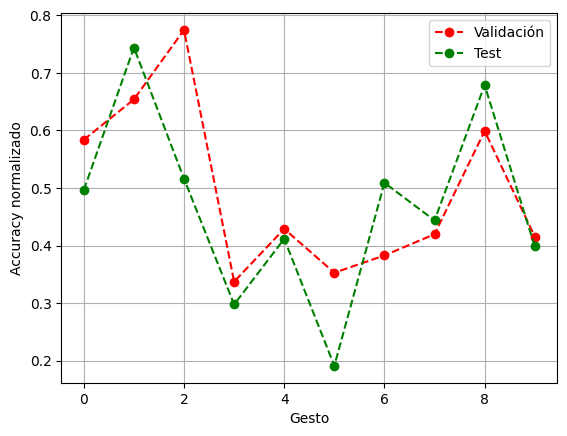

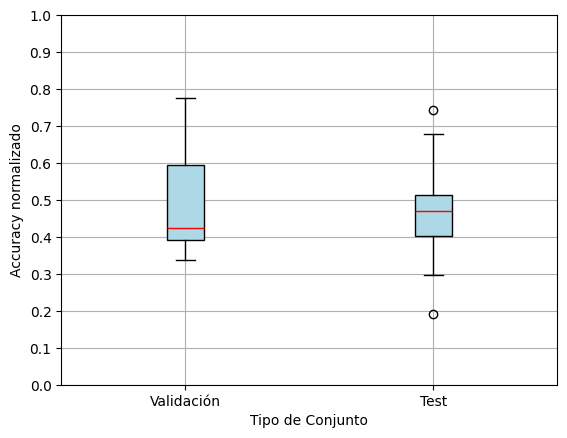

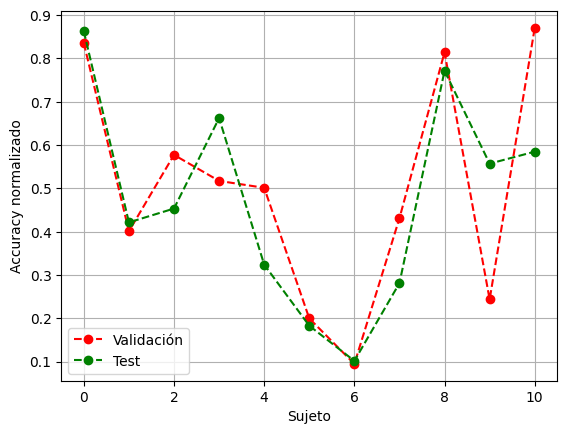

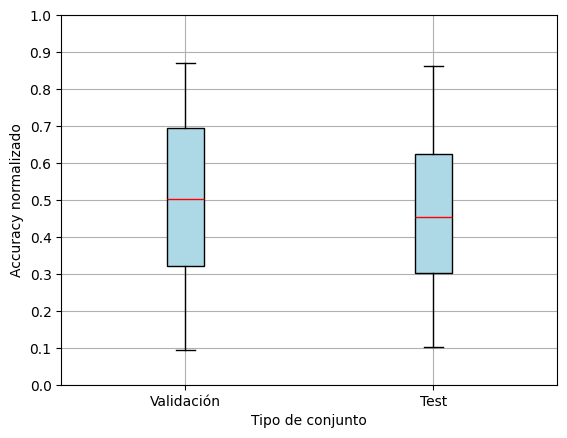

In [ ]:
val_vs_test(mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto, "Estrategia 5", False)

## Estrategia 5 con normalización

In [ ]:
nombre_exp = "GI_estrategia5_normalizado_particion1_sujeto"
acc_val_list = []
acc_test_list = []

for i in range(11): # 11 es la cantidad de sujetos, por lo tanto, la cantidad de experimentos
  dir = nombre_exp + str(i)
  os.chdir("/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3/" + dir) # me situo en el directorio
  acc_val_list.append(joblib.load("cm_val_" + dir + ".pkl"))
  acc_test_list.append(joblib.load("cm_test_" + dir + ".pkl"))

def acc_x_clase(cm):
  # recibe como entrada la matriz de confusion
  diagonal_norm = np.zeros(cm.shape[0], dtype=np.float32)
  for i in range(cm.shape[0]):
    diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])
    # if (np.sum(cm[:, i])) == 0:
    #   diagonal_norm[i] = 0

  return diagonal_norm

diagonales_val_e5_norm = np.zeros((11, 10), dtype=np.float32)  # 11 cant de sujetos, 10 cant de gestos
diagonales_test_e5_norm = np.zeros((11, 10), dtype=np.float32)

for i in range(11):
  diagonales_val_e5_norm[i, :] = acc_x_clase(acc_val_list[i])
  diagonales_test_e5_norm[i, :] = acc_x_clase(acc_test_list[i])

mean_diagonales_val_e5_norm_x_gesto = np.nanmean(diagonales_val_e5_norm, axis = 0)
mean_diagonales_test_e5_norm_x_gesto = np.nanmean(diagonales_test_e5_norm, axis = 0)

mean_diagonales_val_e5_norm_x_sujeto = np.nanmean(diagonales_val_e5_norm, axis = 1)
mean_diagonales_test_e5_norm_x_sujeto = np.nanmean(diagonales_test_e5_norm, axis = 1)

# para reciclar código en la visualización
diagonales_val = diagonales_val_e5_norm.copy()
diagonales_test = diagonales_test_e5_norm.copy()
mean_diagonales_val_x_gesto = mean_diagonales_val_e5_norm_x_gesto.copy()
mean_diagonales_test_x_gesto = mean_diagonales_test_e5_norm_x_gesto.copy()
mean_diagonales_val_x_sujeto = mean_diagonales_val_e5_norm_x_sujeto.copy()
mean_diagonales_test_x_sujeto = mean_diagonales_test_e5_norm_x_sujeto.copy()

nombre_estrategia = "Estrategia 5 con normalización"

<ipython-input-11-824361cffe82>:15: RuntimeWarning: invalid value encountered in scalar divide
  diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])


In [ ]:
print('TEST: Distribución por gesto. Media: '+str(np.mean(mean_diagonales_test_x_gesto))+ ', mediana: '+str(np.median(mean_diagonales_test_x_gesto))+ ', std: '+str(np.std(mean_diagonales_test_x_gesto)))

TEST: Distribución por gesto. Media: 0.48074928, mediana: 0.4762895, std: 0.11186717


### Gráficos val vs test

VAL: Distribución por gesto. Media: 0.5333554
Std: 0.10037242
TEST: Distribución por gesto. Media: 0.48074928
Std: 0.11186717
VAL: Distribución por sujeto. Media: 0.53479713
Std: 0.17970103
TEST: Distribución por sujeto. Media: 0.48373288
Std: 0.23033403


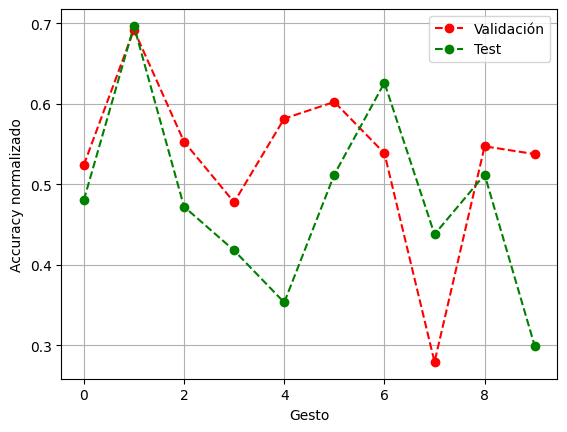

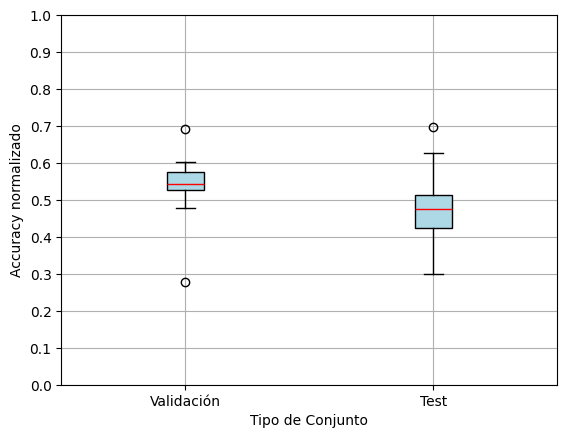

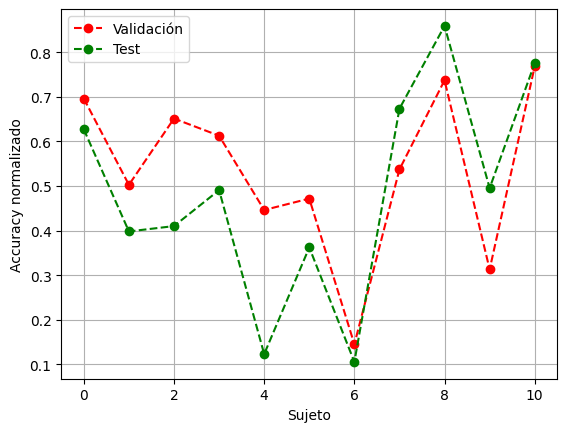

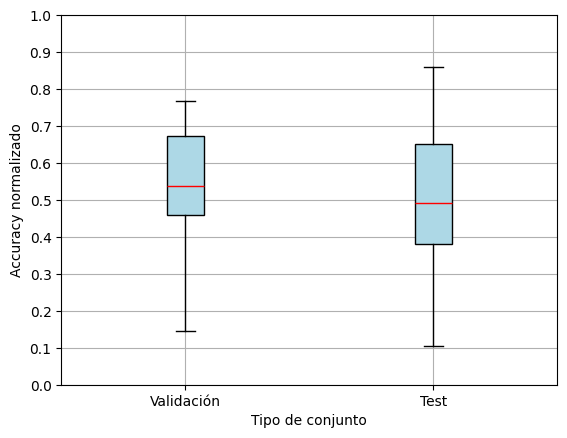

In [ ]:
val_vs_test(mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto, "Estrategia 5 con normalización", False)

### Mapa de calor: gesto, sujeto, accuracy

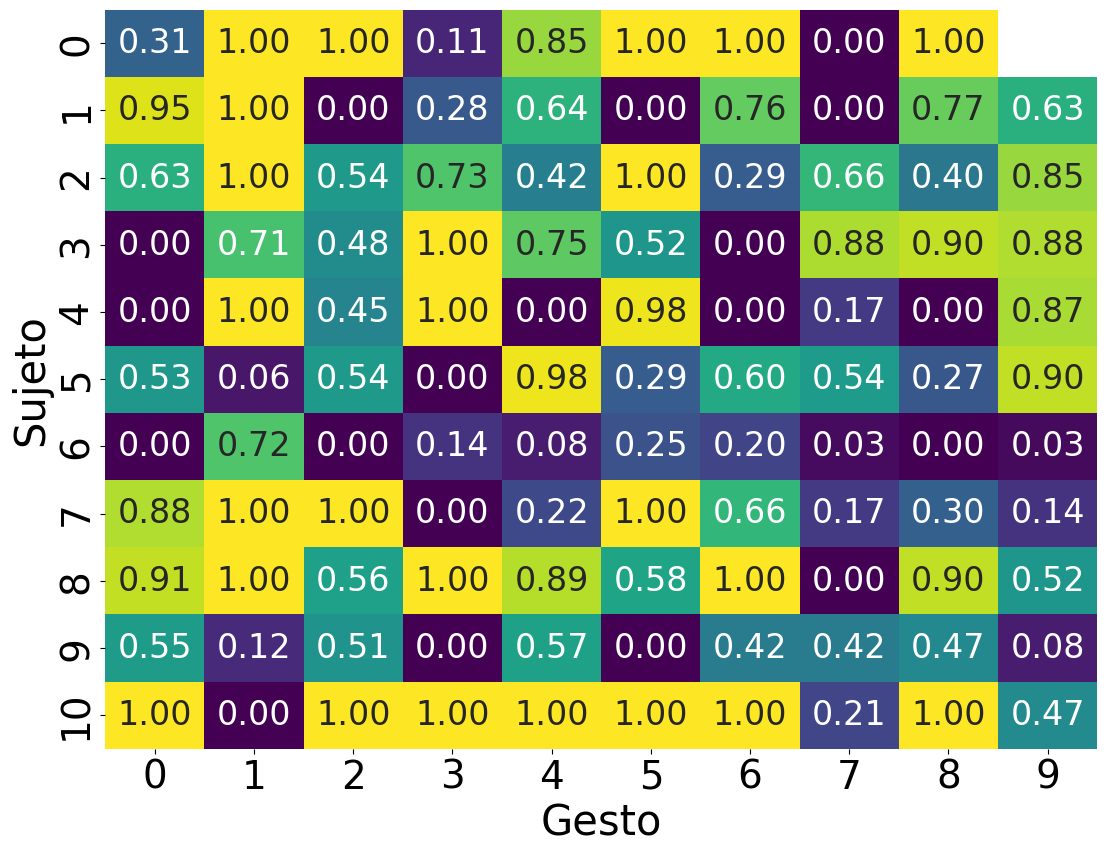

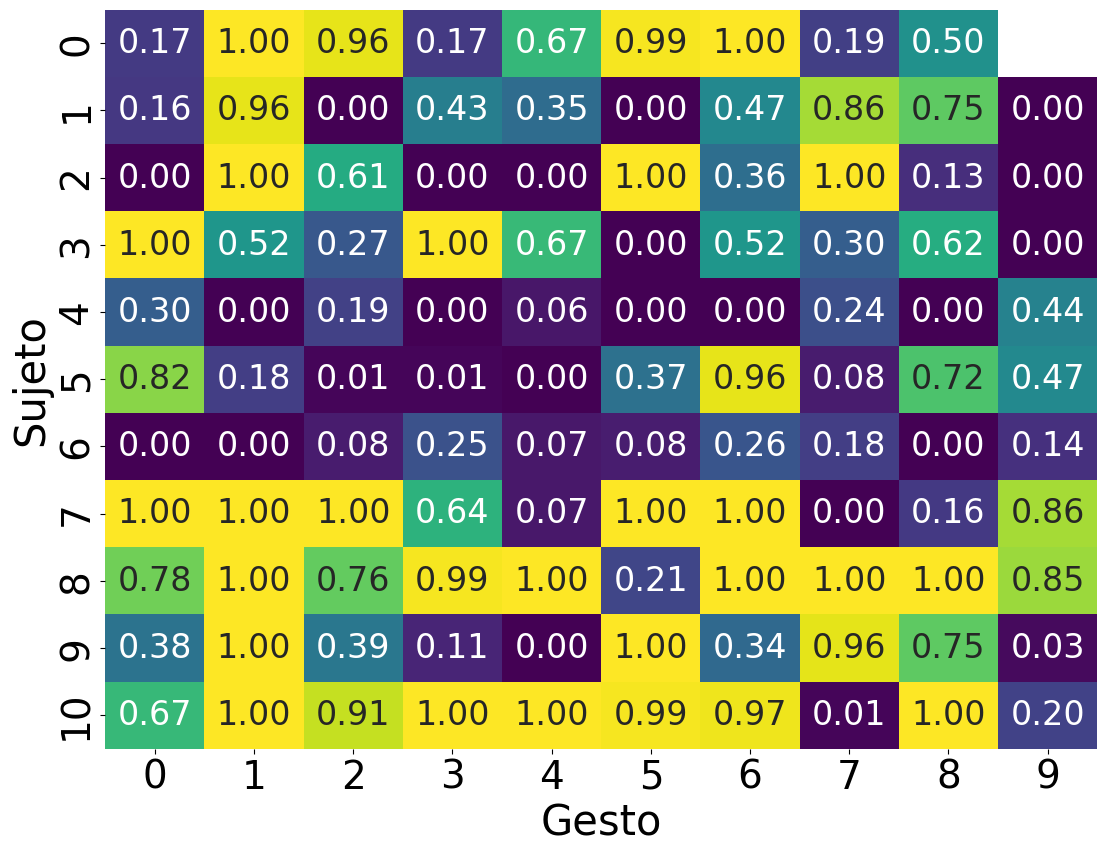

In [ ]:
mapa_calor_sujeto(diagonales_val, "Estrategia 5 con normalización, visualización de accuracy en función de gesto y sujeto, validación", False)
mapa_calor_sujeto(diagonales_test, "Estrategia 5 con normalización, visualización de accuracy en función de gesto y sujeto, test", False)

## Estrategia 4 con normalización

In [ ]:
nombre_exp = "GI_estrategia4_sujeto"
nombre_exp1 = "_normalizado"
acc_val_list = []
acc_test_list = []

for i in range(11): # 11 es la cantidad de sujetos, por lo tanto, la cantidad de experimentos
  dir = nombre_exp + str(i) + nombre_exp1
  os.chdir("/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3/" + dir) # me situo en el directorio
  acc_val_list.append(joblib.load("cm_val_" + dir + ".pkl"))
  acc_test_list.append(joblib.load("cm_test_" + dir + ".pkl"))

def acc_x_clase(cm):
  # recibe como entrada la matriz de confusion
  diagonal_norm = np.zeros(cm.shape[0], dtype=np.float32)
  for i in range(cm.shape[0]):
    diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])
    # if (np.sum(cm[:, i])) == 0:
    #   diagonal_norm[i] = 0

  return diagonal_norm

diagonales_val_e4_norm = np.zeros((11, 10), dtype=np.float32)  # 11 cant de sujetos, 10 cant de gestos
diagonales_test_e4_norm = np.zeros((11, 10), dtype=np.float32)

for i in range(11):
  diagonales_val_e4_norm[i, :] = acc_x_clase(acc_val_list[i])
  diagonales_test_e4_norm[i, :] = acc_x_clase(acc_test_list[i])

mean_diagonales_val_e4_norm_x_gesto = np.nanmean(diagonales_val_e4_norm, axis = 0)
mean_diagonales_test_e4_norm_x_gesto = np.nanmean(diagonales_test_e4_norm, axis = 0)

mean_diagonales_val_e4_norm_x_sujeto = np.nanmean(diagonales_val_e4_norm, axis = 1)
mean_diagonales_test_e4_norm_x_sujeto = np.nanmean(diagonales_test_e4_norm, axis = 1)

# para reciclar código en la visualización
diagonales_val = diagonales_val_e4_norm.copy()
diagonales_test = diagonales_test_e4_norm.copy()
mean_diagonales_val_x_gesto_e4norm = mean_diagonales_val_e4_norm_x_gesto.copy()
mean_diagonales_test_x_gesto_e4norm = mean_diagonales_test_e4_norm_x_gesto.copy()
mean_diagonales_val_x_sujeto_e4norm = mean_diagonales_val_e4_norm_x_sujeto.copy()
mean_diagonales_test_x_sujeto_e4norm = mean_diagonales_test_e4_norm_x_sujeto.copy()

nombre_estrategia = "Estrategia 4 con normalización"

<ipython-input-13-b3a0f21a55a6>:16: RuntimeWarning: invalid value encountered in scalar divide
  diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])


In [ ]:
print('TEST: Distribución por gesto. Media: '+str(np.mean(mean_diagonales_test_x_gesto_e4norm))+ ', mediana: '+str(np.median(mean_diagonales_test_x_gesto_e4norm))+ ', std: '+str(np.std(mean_diagonales_test_x_gesto_e4norm)))

TEST: Distribución por gesto. Media: 0.5562224, mediana: 0.54566514, std: 0.12779209


### Gráficos val vs test

<ipython-input-4-3d600609a5e4>:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Validación', 'Test'], patch_artist=True,
<ipython-input-4-3d600609a5e4>:91: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Validación', 'Test'], patch_artist=True,


VAL: Distribución por gesto. Media: 0.6903051
Std: 0.14258291
TEST: Distribución por gesto. Media: 0.56164324
Std: 0.12843083
VAL: Distribución por sujeto. Media: 0.6913558
Std: 0.22288601
TEST: Distribución por sujeto. Media: 0.5607998
Std: 0.2319378


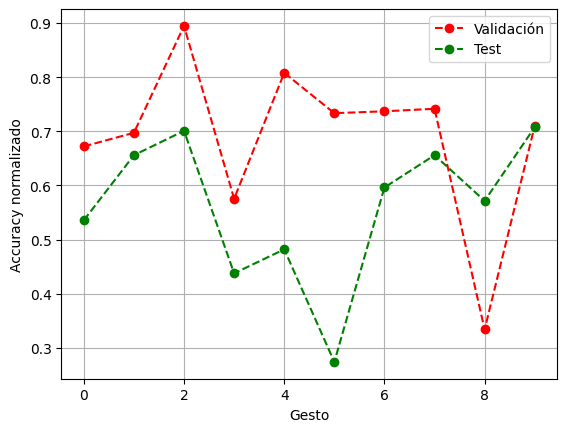

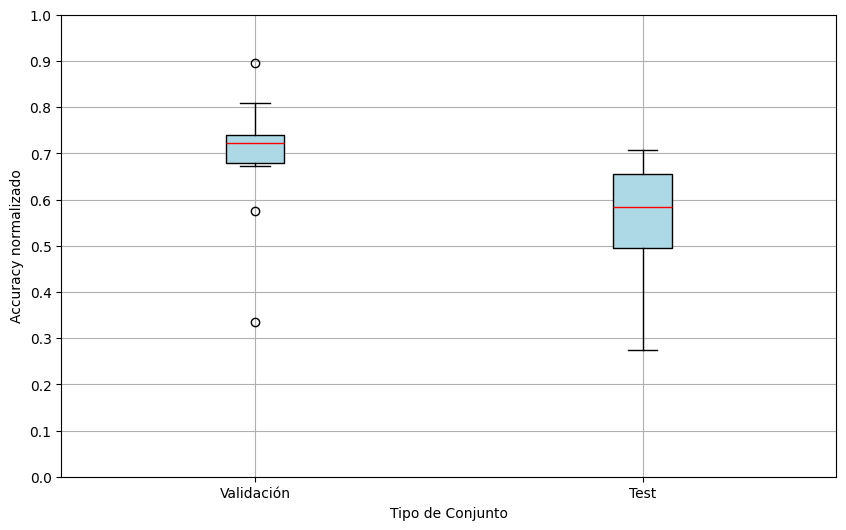

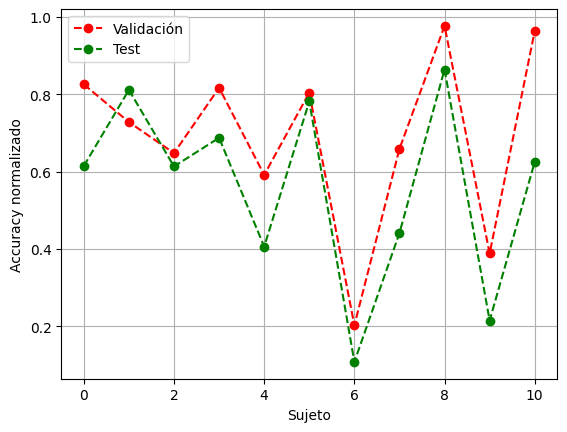

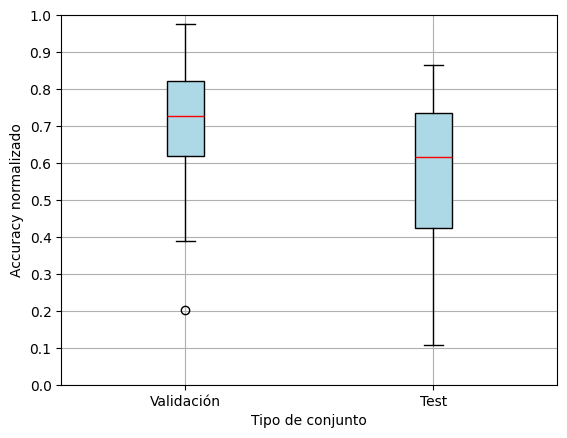

In [ ]:
val_vs_test(mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto, "Estrategia 4 con normalización", False)

### Mapa de calor: gesto, sujeto, accuracy

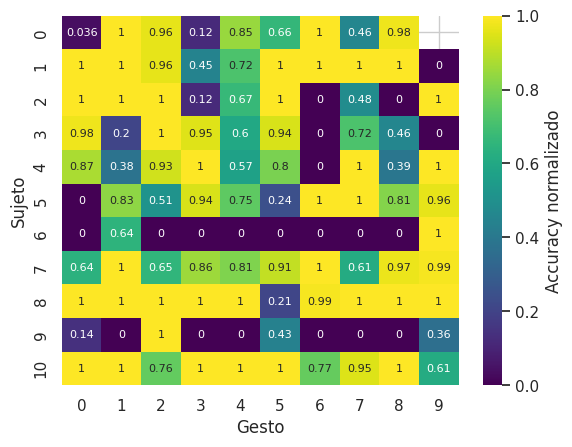

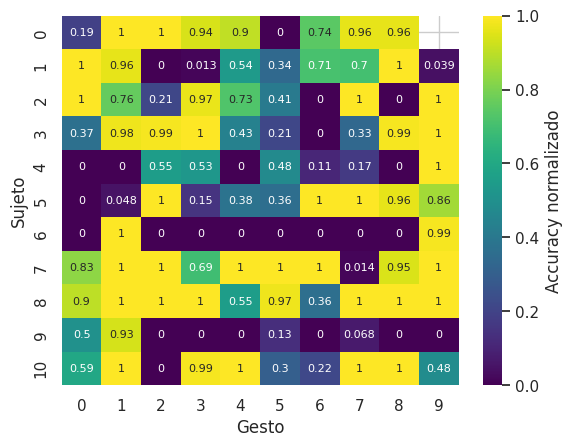

In [ ]:
mapa_calor(diagonales_val, "Estrategia 4 con normalización, visualización de accuracy en función de gesto y sujeto, validación", False)
mapa_calor(diagonales_test, "Estrategia 4 con normalización, visualización de accuracy en función de gesto y sujeto, test", False)

## Estrategia 4

In [ ]:
nombre_exp = "GI_estrategia4_sujeto"

acc_val_list = []
acc_test_list = []

for i in range(11): # 11 es la cantidad de sujetos, por lo tanto, la cantidad de experimentos
  dir = nombre_exp + str(i)
  os.chdir("/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3/" + dir) # me situo en el directorio
  acc_val_list.append(joblib.load("cm_val_" + dir + ".pkl"))
  acc_test_list.append(joblib.load("cm_test_" + dir + ".pkl"))

def acc_x_clase(cm):
  # recibe como entrada la matriz de confusion
  diagonal_norm = np.zeros(cm.shape[0], dtype=np.float32)
  for i in range(cm.shape[0]):
    diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])
    # if (np.sum(cm[:, i])) == 0:
    #   diagonal_norm[i] = 0

  return diagonal_norm

diagonales_val_e4 = np.zeros((11, 10), dtype=np.float32)  # 11 cant de sujetos, 10 cant de gestos
diagonales_test_e4 = np.zeros((11, 10), dtype=np.float32)

for i in range(11):
  diagonales_val_e4[i, :] = acc_x_clase(acc_val_list[i])
  diagonales_test_e4[i, :] = acc_x_clase(acc_test_list[i])

# por gesto
mean_diagonales_val_e4_x_gesto = np.nanmean(diagonales_val_e4, axis = 0)
mean_diagonales_test_e4_x_gesto = np.nanmean(diagonales_test_e4, axis = 0)

# por sujeto
mean_diagonales_val_e4_x_sujeto = np.nanmean(diagonales_val_e4, axis = 1)
mean_diagonales_test_e4_x_sujeto = np.nanmean(diagonales_test_e4, axis = 1)

# para reciclar código en la visualización
diagonales_val = diagonales_val_e4.copy()
diagonales_test = diagonales_test_e4.copy()
mean_diagonales_val_x_gesto = mean_diagonales_val_e4_x_gesto.copy()
mean_diagonales_test_x_gesto = mean_diagonales_test_e4_x_gesto.copy()
mean_diagonales_val_x_sujeto = mean_diagonales_val_e4_x_sujeto.copy()
mean_diagonales_test_x_sujeto = mean_diagonales_test_e4_x_sujeto.copy()

nombre_estrategia = "Estrategia 4"

<ipython-input-15-c5d71e9a1aea>:16: RuntimeWarning: invalid value encountered in scalar divide
  diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])


In [ ]:
print('TEST: Distribución por gesto. Media: '+str(np.mean(mean_diagonales_test_x_gesto))+ ', mediana: '+str(np.median(mean_diagonales_test_x_gesto))+ ', std: '+str(np.std(mean_diagonales_test_x_gesto)))

TEST: Distribución por gesto. Media: 0.56164324, mediana: 0.5837984, std: 0.12843083


### Gráficos val vs test

VAL: Distribución por gesto. Media: 0.6903051
Std: 0.14258291
TEST: Distribución por gesto. Media: 0.56164324
Std: 0.12843083
VAL: Distribución por sujeto. Media: 0.6913558
Std: 0.22288601
TEST: Distribución por sujeto. Media: 0.5607998
Std: 0.2319378


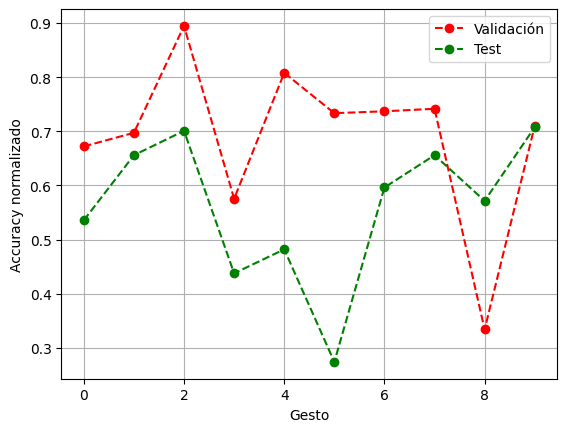

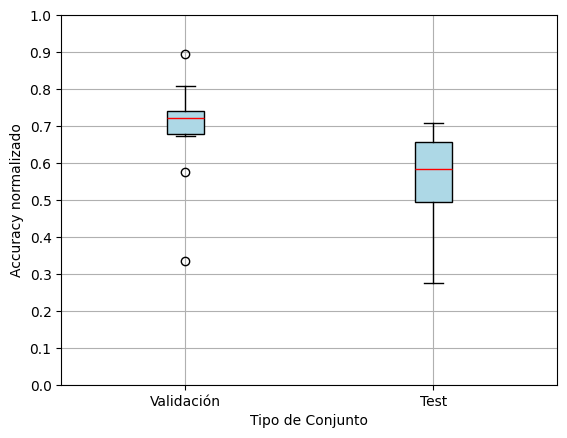

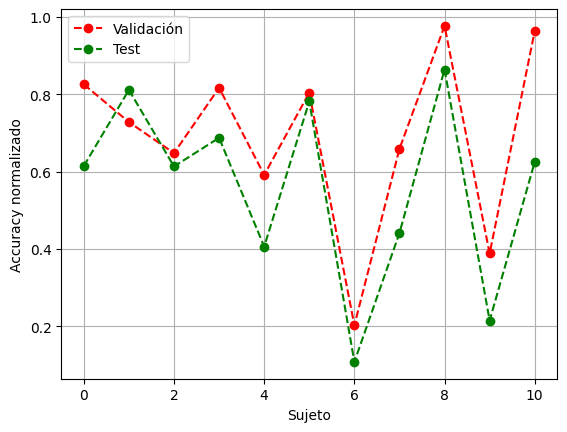

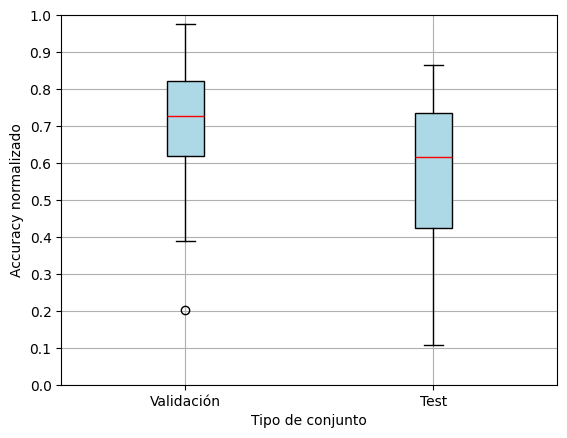

In [ ]:
val_vs_test(mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto, nombre_estrategia, False)

### Mapa de calor: gesto, sujeto, accuracy

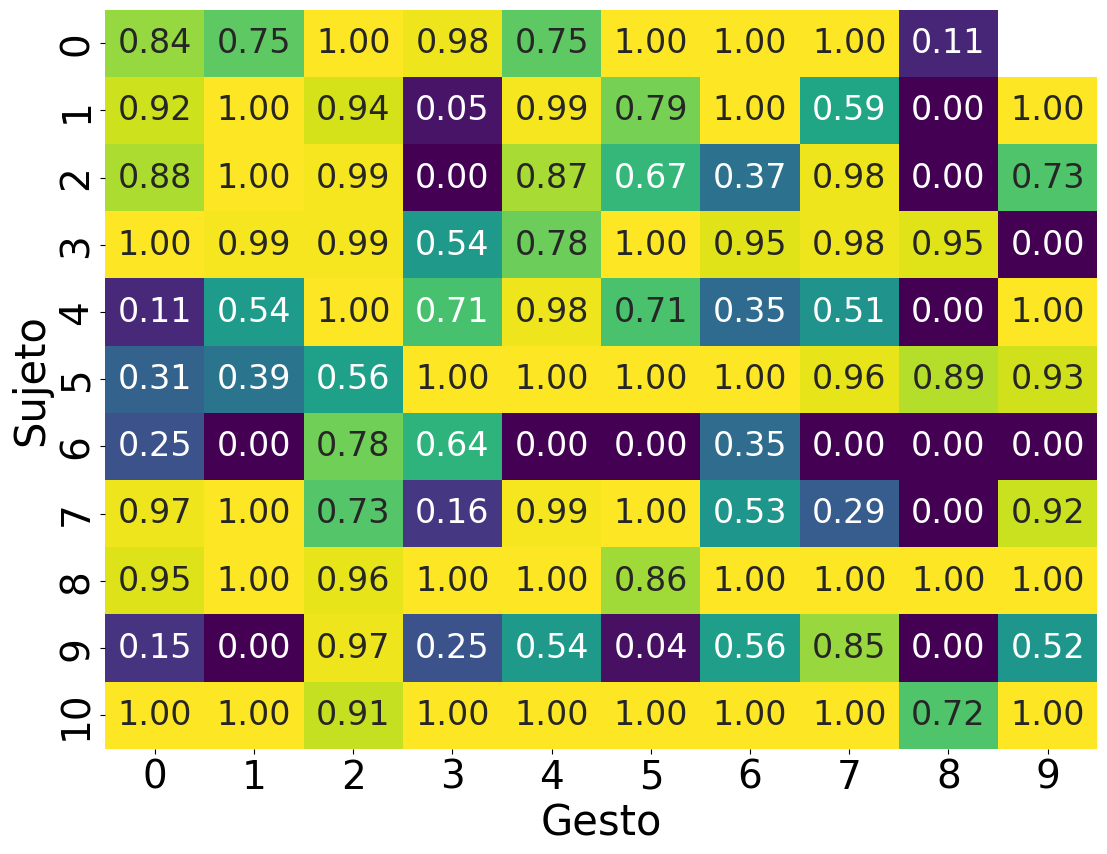

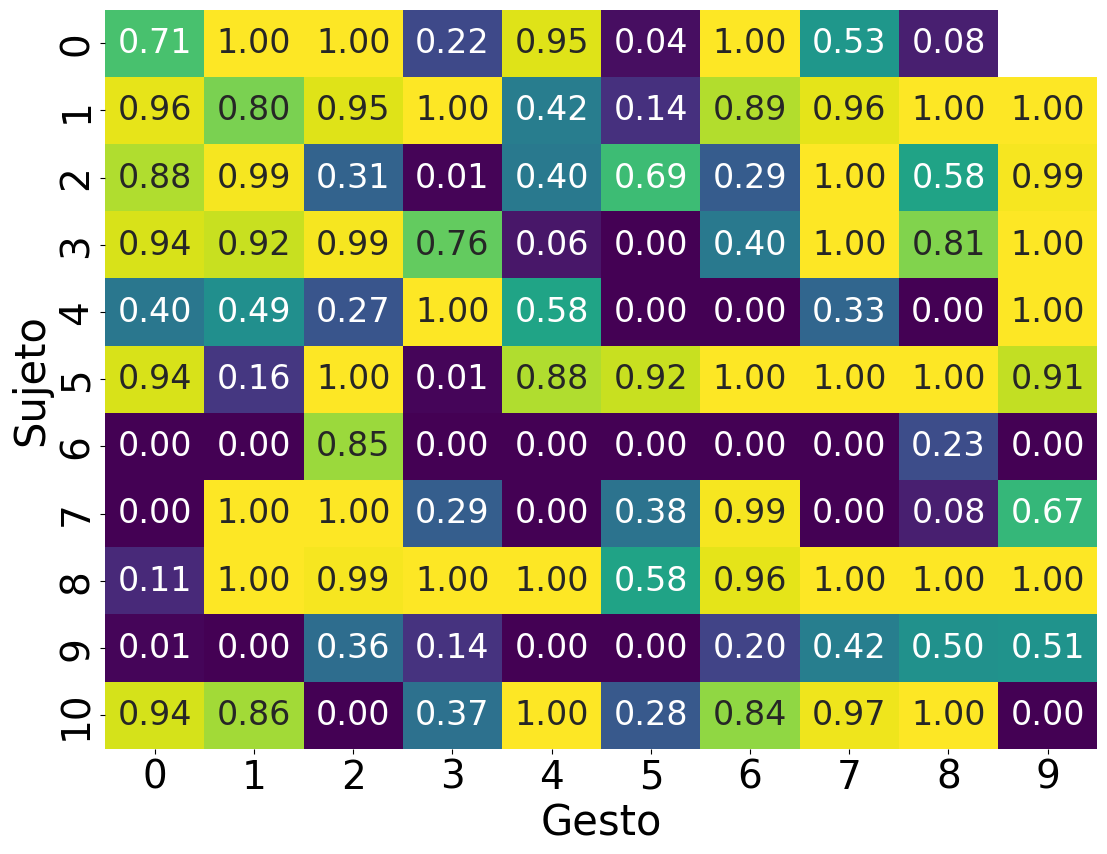

In [ ]:
mapa_calor_sujeto(diagonales_val, "Estrategia 4, visualización de accuracy en función de gesto y sujeto, validación", False)
mapa_calor_sujeto(diagonales_test, "Estrategia 4, visualización de accuracy en función de gesto y sujeto, test", False)

<ipython-input-32-3fc7fba87136>:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mean_diagonales_test_x_gesto, mean_diagonales_test_x_gesto_e4norm], labels=['Crudo', 'Normalizado'])
<ipython-input-32-3fc7fba87136>:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mean_diagonales_test_x_sujeto, mean_diagonales_test_x_sujeto_e4norm], labels=['Crudo', 'Normalizado'])


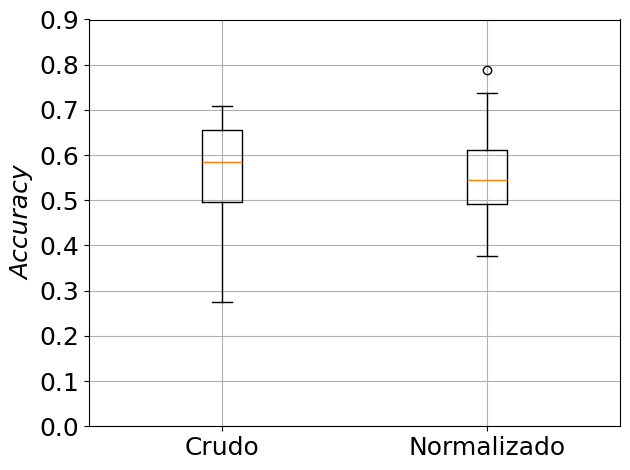

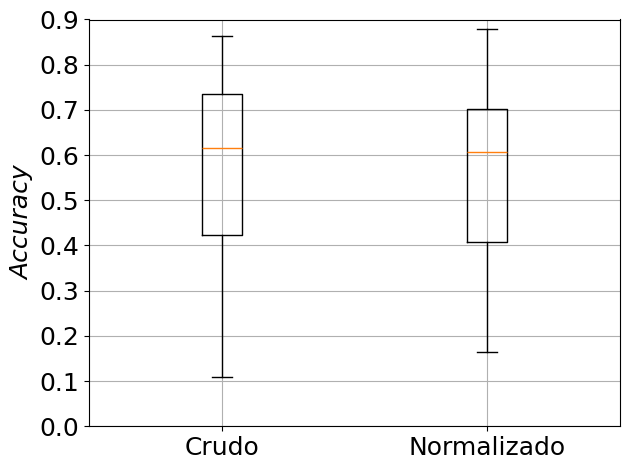

In [ ]:
# # POR GESTO
# plt.figure()
# # Crear el boxplot tiempo inferencia por sujeto
# plt.boxplot([mean_diagonales_test_x_gesto, mean_diagonales_test_x_gesto_e4norm], labels=['Crudo', 'Normalizado'])

# # Ajustar el tamaño del texto
# # plt.xlabel('Variable considerada', fontsize=18)
# plt.ylabel('Accuracy', fontsize=18, style='italic')
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)

# # Añadir una cuadrícula y escala logarítmica
# plt.grid()
# plt.tight_layout()

# # Guardar la figura
# plt.savefig('Estrategia 4, por gesto boxplots.pdf', bbox_inches='tight')

plt.figure()
# Crear el boxplot tiempo inferencia por sujeto
plt.boxplot([mean_diagonales_test_x_gesto, mean_diagonales_test_x_gesto_e4norm], labels=['Crudo', 'Normalizado'])

# Ajustar el tamaño del texto
# plt.xlabel('Variable considerada', fontsize=18)
plt.ylabel('Accuracy', fontsize=18, style='italic')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 0.9)

# Añadir una cuadrícula y escala logarítmica
plt.grid()
plt.tight_layout()

# Guardar la figura
plt.savefig('Estrategia 4, por gesto boxplots.pdf', bbox_inches='tight')

# POR SUJETO
plt.figure()
# Crear el boxplot tiempo inferencia por sujeto
plt.boxplot([mean_diagonales_test_x_sujeto, mean_diagonales_test_x_sujeto_e4norm], labels=['Crudo', 'Normalizado'])

# Ajustar el tamaño del texto
# plt.xlabel('Variable considerada', fontsize=18)
plt.ylabel('Accuracy', fontsize=18, style='italic')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 0.9)

# Añadir una cuadrícula y escala logarítmica
plt.grid()
plt.tight_layout()

# Guardar la figura
plt.savefig('Estrategia 4, por sujeto boxplots.pdf', bbox_inches='tight')

## Estrategia 3

train/test DB3 por sujeto. Se tomaron 5 particiones en un principio, y luego se tomaron otras 5 particiones con lr fixed

### Valor de lr estándar

In [ ]:
nombre_exp = "GI_estrategia3_particion"

cant_exps = 5

acc_val_list = []
acc_test_list = []

for i in range(1, 6): # 11 es la cantidad de sujetos, por lo tanto, la cantidad de experimentos
  dir = nombre_exp + str(i)
  os.chdir("/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3/" + dir) # me situo en el directorio
  acc_val_list.append(joblib.load("cm_val_" + dir + ".pkl"))
  acc_test_list.append(joblib.load("cm_test_" + dir + ".pkl"))

def acc_x_clase(cm):
  # recibe como entrada la matriz de confusion
  diagonal_norm = np.zeros(cm.shape[0], dtype=np.float32)
  for i in range(cm.shape[0]):
    diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])

  return diagonal_norm

diagonales_val_e3 = np.zeros((cant_exps, 10), dtype=np.float32)  # 11 cant de sujetos, 10 cant de gestos
diagonales_test_e3 = np.zeros((cant_exps, 10), dtype=np.float32)

for i in range(cant_exps):
  diagonales_val_e3[i, :] = acc_x_clase(acc_val_list[i])
  diagonales_test_e3[i, :] = acc_x_clase(acc_test_list[i])

mean_diagonales_val_e3_x_gesto = np.nanmean(diagonales_val_e3, axis = 0)
mean_diagonales_test_e3_x_gesto = np.nanmean(diagonales_test_e3, axis = 0)

mean_diagonales_val_e3_x_sujeto = np.nanmean(diagonales_val_e3, axis = 1)
mean_diagonales_test_e3_x_sujeto = np.nanmean(diagonales_test_e3, axis = 1)

# para reciclar código en la visualización
diagonales_val = diagonales_val_e3.copy()
diagonales_test = diagonales_test_e3.copy()
mean_diagonales_val_x_gesto = mean_diagonales_val_e3_x_gesto.copy()
mean_diagonales_test_x_gesto = mean_diagonales_test_e3_x_gesto.copy()
mean_diagonales_val_x_sujeto = mean_diagonales_val_e3_x_sujeto.copy()
mean_diagonales_test_x_sujeto = mean_diagonales_test_e3_x_sujeto.copy()

nombre_estrategia = "Estrategia 3"



In [ ]:
print('TEST: Distribución por gesto. Media: '+str(np.mean(mean_diagonales_test_x_gesto))+ ', mediana: '+str(np.median(mean_diagonales_test_x_gesto))+ ', std: '+str(np.std(mean_diagonales_test_x_gesto)))

TEST: Distribución por gesto. Media: 0.11425463, mediana: 0.1061943, std: 0.068520606


VAL: Distribución por gesto. Media: 0.25525743
Std: 0.13800395
TEST: Distribución por gesto. Media: 0.11425463
Std: 0.068520606
VAL: Distribución por sujeto. Media: 0.2552574
Std: 0.07339263
TEST: Distribución por sujeto. Media: 0.11425463
Std: 0.04288291


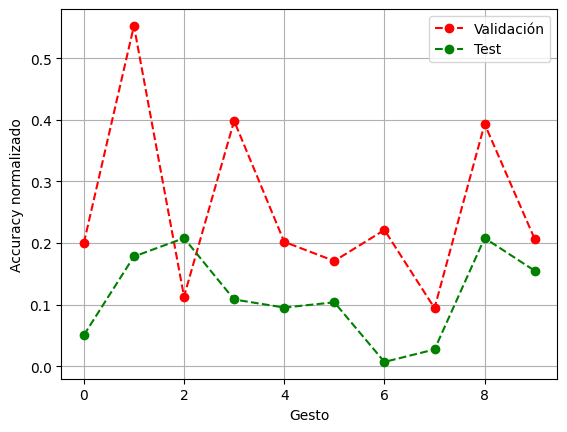

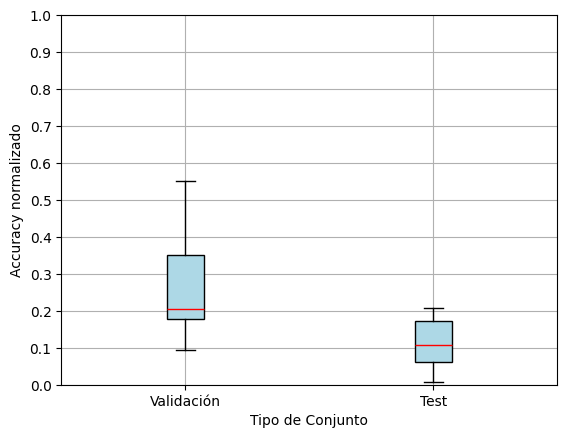

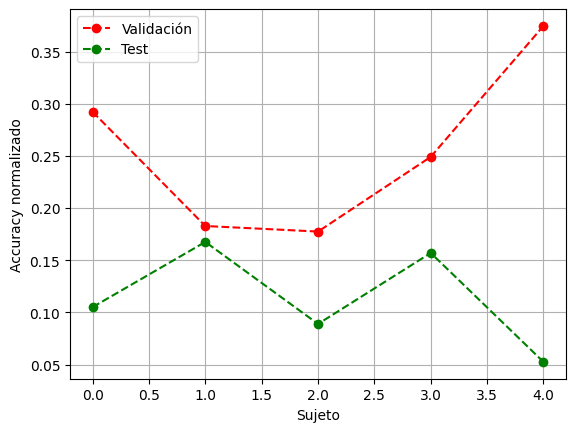

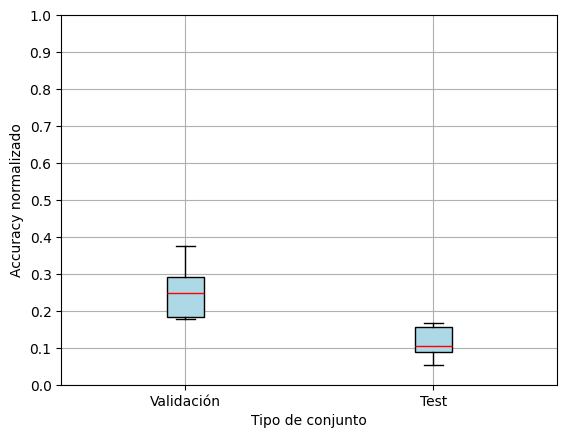

In [ ]:
val_vs_test(mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto, nombre_estrategia, False)

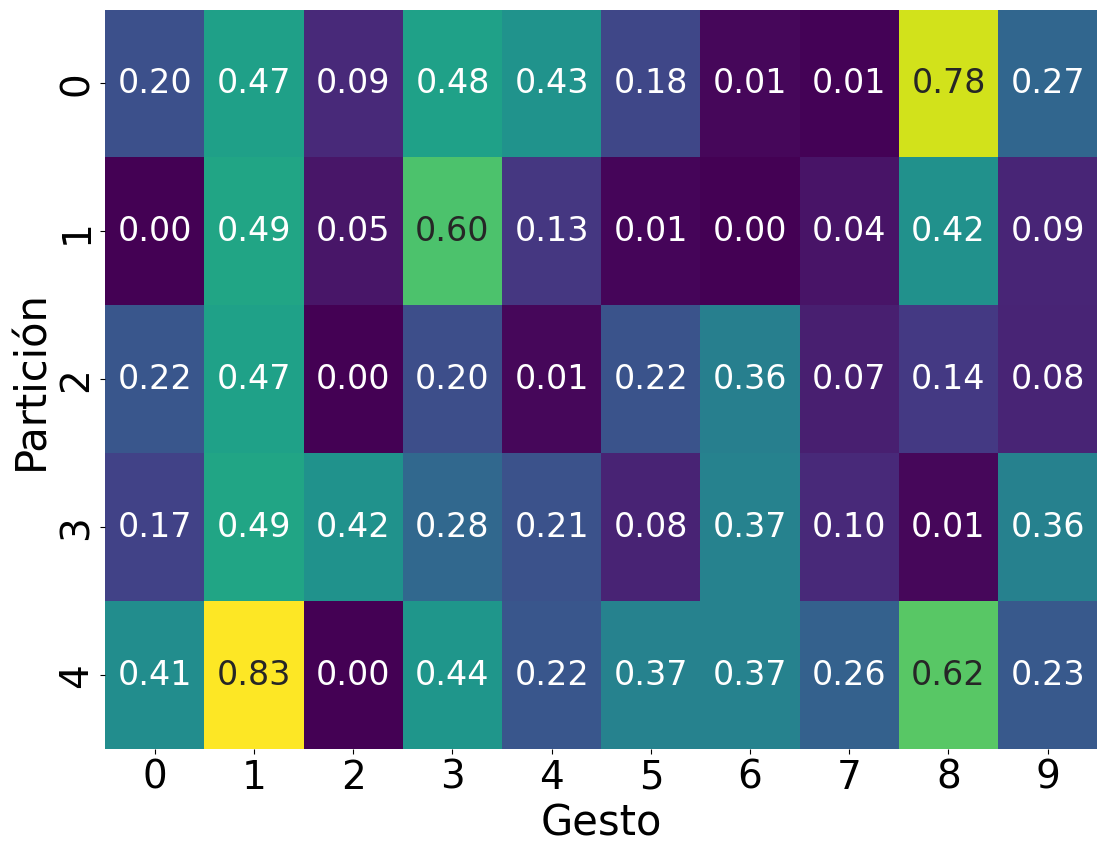

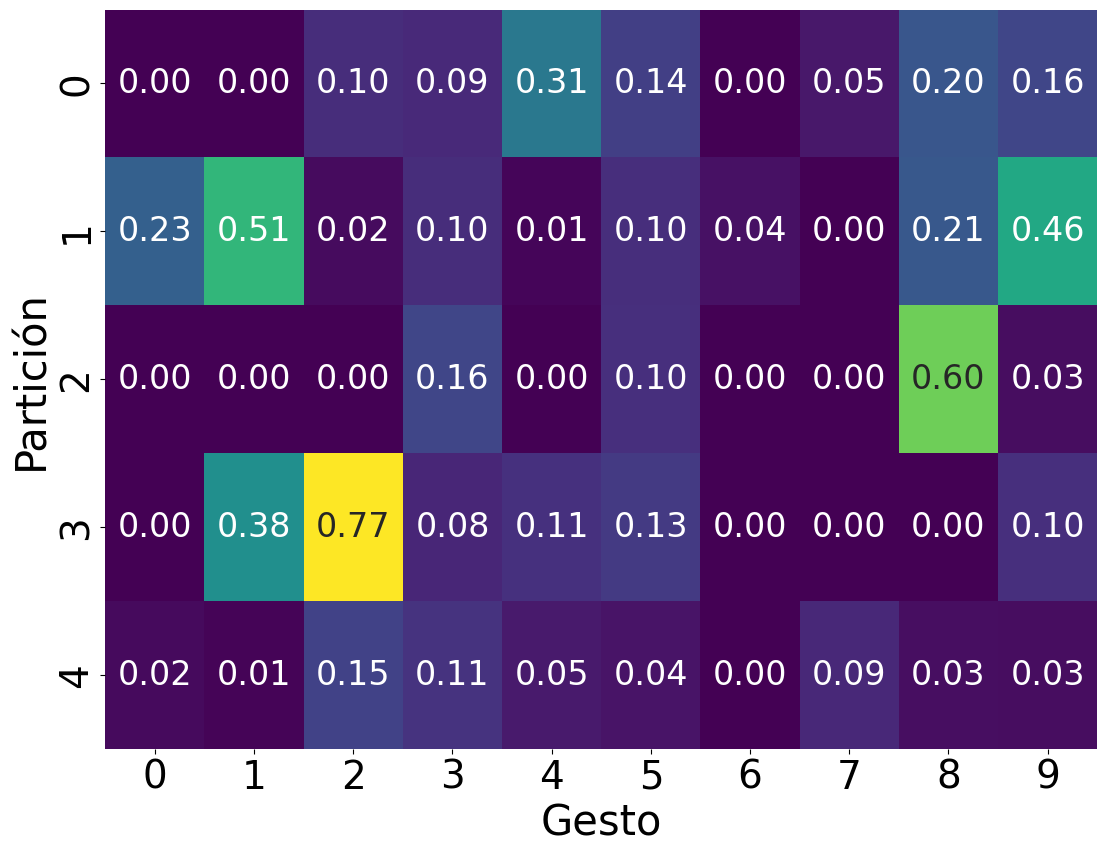

In [ ]:
mapa_calor_sujeto(diagonales_val, "Estrategia 3, visualización de accuracy en función de gesto y sujeto, validación", False)
mapa_calor_sujeto(diagonales_test, "Estrategia 3, visualización de accuracy en función de gesto y sujeto, test", False)

<ipython-input-25-618e8148bce2>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mean_diagonales_test_e3_x_sujeto, mean_diagonales_test_e3_x_gesto], labels=['Sujeto', 'Gesto'])


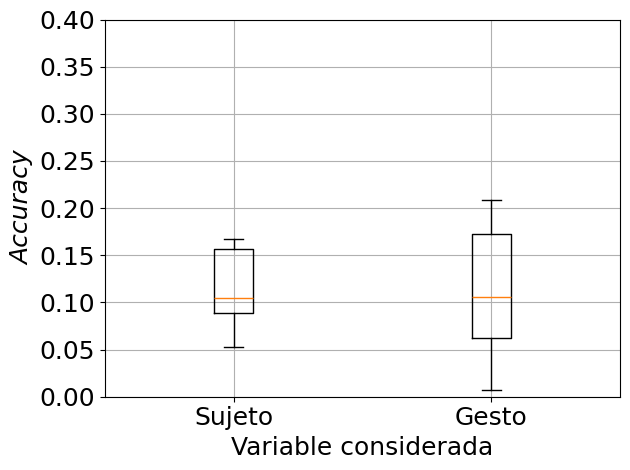

In [ ]:
plt.figure()
# Crear el boxplot tiempo inferencia por sujeto
plt.boxplot([mean_diagonales_test_e3_x_sujeto, mean_diagonales_test_e3_x_gesto], labels=['Sujeto', 'Gesto'])

# Ajustar el tamaño del texto
plt.xlabel('Variable considerada', fontsize=18)
plt.ylabel('Accuracy', fontsize=18, style='italic')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Fijar la escala del eje y
plt.ylim(0, 0.4)

# Añadir una cuadrícula y escala logarítmica
plt.grid()
plt.tight_layout()

# Guardar la figura
plt.savefig('Estrategia 3, boxplots.pdf', bbox_inches='tight')

<ipython-input-7-30f3a5bc3757>:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Por sujeto', 'Por gesto'], patch_artist=True,


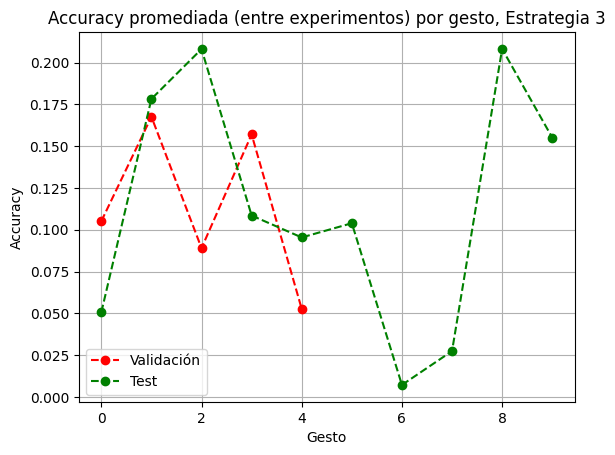

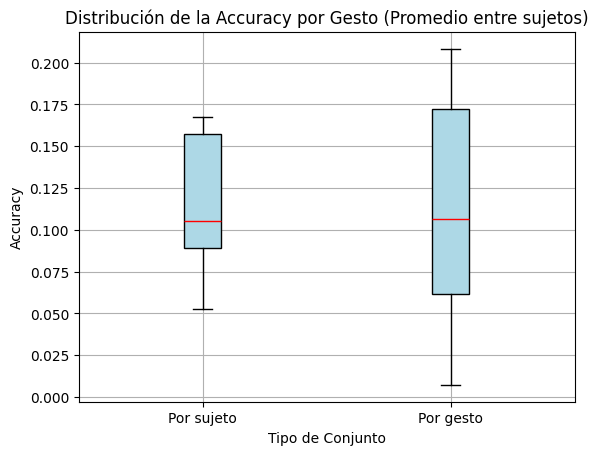

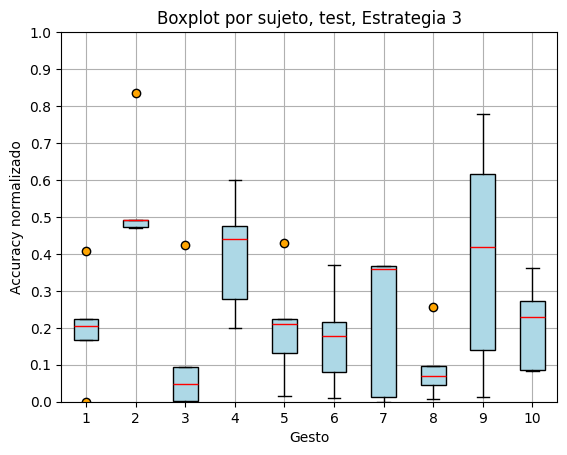

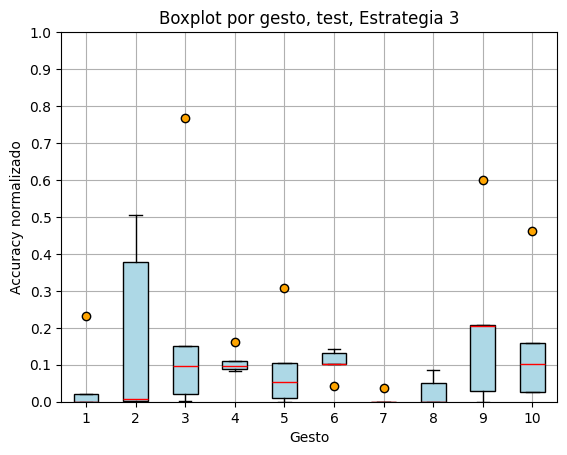

In [ ]:
plt.figure()
plt.plot(mean_diagonales_test_e3_x_sujeto, '--o', color='r')
plt.plot(mean_diagonales_test_e3_x_gesto, '--o', color='g')
plt.grid()
plt.xlabel('Gesto')
plt.ylabel('Accuracy')
plt.legend(['Validación', 'Test'])
plt.title('Accuracy promediada (entre experimentos) por gesto, Estrategia 3')

data = [mean_diagonales_test_e3_x_sujeto, mean_diagonales_test_e3_x_gesto]

plt.figure()  # figsize=(8,6)
plt.boxplot(data, labels=['Por sujeto', 'Por gesto'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.grid(True)
plt.xlabel('Tipo de Conjunto')
plt.ylabel('Accuracy')
plt.title('Distribución de la Accuracy por Gesto (Promedio entre sujetos)')

boxplot_x_gesto(diagonales_val, "Boxplot por sujeto, test, Estrategia 3", True)

boxplot_x_gesto(diagonales_test, "Boxplot por gesto, test, Estrategia 3", True)

### lr fixed

In [ ]:
nombre_exp = "GI_estrategia3_lr_fixed_particion"

cant_exps = 5

acc_val_list = []
acc_test_list = []

for i in range(1, 6): # 11 es la cantidad de sujetos, por lo tanto, la cantidad de experimentos
  dir = nombre_exp + str(i)
  os.chdir("/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3/" + dir) # me situo en el directorio
  acc_val_list.append(joblib.load("cm_val_" + dir + ".pkl"))
  acc_test_list.append(joblib.load("cm_test_" + dir + ".pkl"))

def acc_x_clase(cm):
  # recibe como entrada la matriz de confusion
  diagonal_norm = np.zeros(cm.shape[0], dtype=np.float32)
  for i in range(cm.shape[0]):
    diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])

  return diagonal_norm

diagonales_val_e3_fixed = np.zeros((cant_exps, 10), dtype=np.float32)  # 11 cant de sujetos, 10 cant de gestos
diagonales_test_e3_fixed = np.zeros((cant_exps, 10), dtype=np.float32)

for i in range(cant_exps):
  diagonales_val_e3_fixed[i, :] = acc_x_clase(acc_val_list[i])
  diagonales_test_e3_fixed[i, :] = acc_x_clase(acc_test_list[i])

mean_diagonales_val_e3_fixed_x_gesto = np.nanmean(diagonales_val_e3_fixed, axis = 0)
mean_diagonales_test_e3_fixed_x_gesto = np.nanmean(diagonales_test_e3_fixed, axis = 0)

mean_diagonales_val_e3_fixed_x_sujeto = np.nanmean(diagonales_val_e3_fixed, axis = 1)
mean_diagonales_test_e3_fixed_x_sujeto = np.nanmean(diagonales_test_e3_fixed, axis = 1)

# para reciclar código en la visualización
diagonales_val = diagonales_val_e3_fixed.copy()
diagonales_test = diagonales_test_e3_fixed.copy()
mean_diagonales_val_x_gesto = mean_diagonales_val_e3_fixed_x_gesto.copy()
mean_diagonales_test_x_gesto = mean_diagonales_test_e3_fixed_x_gesto.copy()
mean_diagonales_val_x_sujeto = mean_diagonales_val_e3_fixed_x_sujeto.copy()
mean_diagonales_test_x_sujeto = mean_diagonales_test_e3_fixed_x_sujeto.copy()

nombre_estrategia = "Estrategia 3, lr fixed"

In [ ]:
print('TEST: Distribución por gesto. Media: '+str(np.mean(mean_diagonales_test_x_gesto))+ ', mediana: '+str(np.median(mean_diagonales_test_x_gesto))+ ', std: '+str(np.std(mean_diagonales_test_x_gesto)))

TEST: Distribución por gesto. Media: 0.14379147, mediana: 0.08242172, std: 0.113342784


<ipython-input-23-e1bc3f3dea54>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mean_diagonales_test_x_sujeto, mean_diagonales_test_x_gesto], labels=['Sujeto', 'Gesto'])


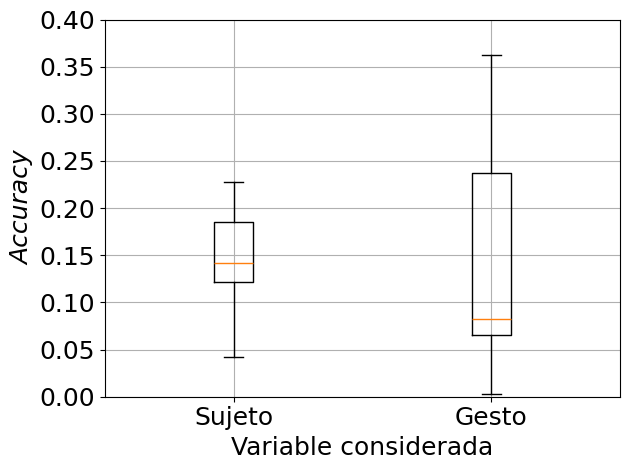

In [ ]:
plt.figure()
# Crear el boxplot tiempo inferencia por sujeto
plt.boxplot([mean_diagonales_test_x_sujeto, mean_diagonales_test_x_gesto], labels=['Sujeto', 'Gesto'])

# Ajustar el tamaño del texto
plt.xlabel('Variable considerada', fontsize=18)
plt.ylabel('Accuracy', fontsize=18, style='italic')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Fijar la escala del eje y
plt.ylim(0, 0.4)

# Añadir una cuadrícula y escala logarítmica
plt.grid()
plt.tight_layout()

# Guardar la figura
plt.savefig('Estrategia 3 lr fixed, boxplots.pdf', bbox_inches='tight')

VAL: Distribución por gesto. Media: 0.14893235
Std: 0.08296453
TEST: Distribución por gesto. Media: 0.14379147
Std: 0.113342784
VAL: Distribución por sujeto. Media: 0.14893237
Std: 0.041182283
TEST: Distribución por sujeto. Media: 0.14379147
Std: 0.06273556


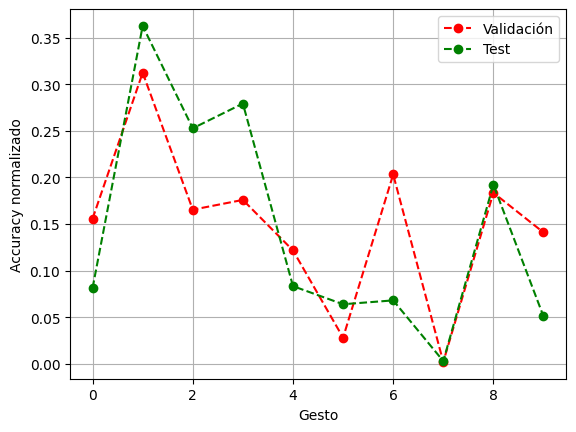

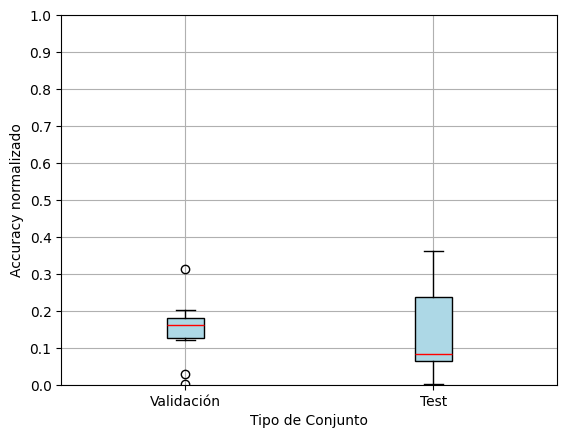

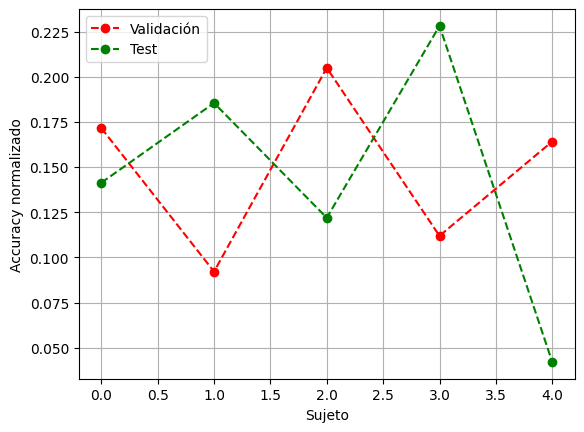

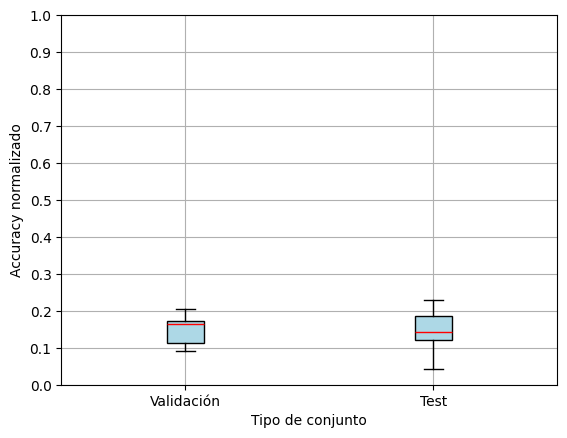

In [ ]:
val_vs_test(mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto, nombre_estrategia, False)

## Estrategia 2
train DB2 + fine tuning DB3 + test DB3

In [ ]:
nombre_exp = "GI_estrategia2_particion"

cant_exps = 1

acc_val_list = []
acc_test_list = []

for i in range(1, 2): # 11 es la cantidad de sujetos, por lo tanto, la cantidad de experimentos
  dir = nombre_exp + str(i)
  os.chdir("/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3/" + dir) # me situo en el directorio
  acc_val_list.append(joblib.load("cm_val_" + dir + ".pkl"))
  acc_test_list.append(joblib.load("cm_test_" + dir + ".pkl"))

def acc_x_clase(cm):
  # recibe como entrada la matriz de confusion
  diagonal_norm = np.zeros(cm.shape[0], dtype=np.float32)
  for i in range(cm.shape[0]):
    diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])

  return diagonal_norm

diagonales_val_e2 = np.zeros((cant_exps, 10), dtype=np.float32)  # 11 cant de sujetos, 10 cant de gestos
diagonales_test_e2 = np.zeros((cant_exps, 10), dtype=np.float32)

for i in range(cant_exps):
  diagonales_val_e2[i, :] = acc_x_clase(acc_val_list[i])
  diagonales_test_e2[i, :] = acc_x_clase(acc_test_list[i])

mean_diagonales_val_e2_x_gesto = np.nanmean(diagonales_val_e2, axis = 0)
mean_diagonales_test_e2_x_gesto = np.nanmean(diagonales_test_e2, axis = 0)

mean_diagonales_val_e2_x_sujeto = np.nanmean(diagonales_val_e2, axis = 1)
mean_diagonales_test_e2_x_sujeto = np.nanmean(diagonales_test_e2, axis = 1)

# para reciclar código en la visualización
diagonales_val = diagonales_val_e2.copy()
diagonales_test = diagonales_test_e2.copy()
mean_diagonales_val_x_gesto = mean_diagonales_val_e2_x_gesto.copy()
mean_diagonales_test_x_gesto = mean_diagonales_test_e2_x_gesto.copy()
mean_diagonales_val_x_sujeto = mean_diagonales_val_e2_x_sujeto.copy()
mean_diagonales_test_x_sujeto = mean_diagonales_test_e2_x_sujeto.copy()

nombre_estrategia = "Estrategia 2"


In [ ]:
print('TEST: Distribución por gesto. Media: '+str(np.mean(mean_diagonales_test_x_gesto))+ ', mediana: '+str(np.median(mean_diagonales_test_x_gesto))+ ', std: '+str(np.std(mean_diagonales_test_x_gesto)))

TEST: Distribución por gesto. Media: 0.080527306, mediana: 0.07743414, std: 0.081104405


In [ ]:
diagonales_test_e2.shape

(1, 10)

VAL: Distribución por gesto. Media: 0.17503707
Std: 0.21324302
TEST: Distribución por gesto. Media: 0.080527306
Std: 0.081104405
VAL: Distribución por sujeto. Media: 0.17503707
Std: 0.0
TEST: Distribución por sujeto. Media: 0.080527306
Std: 0.0


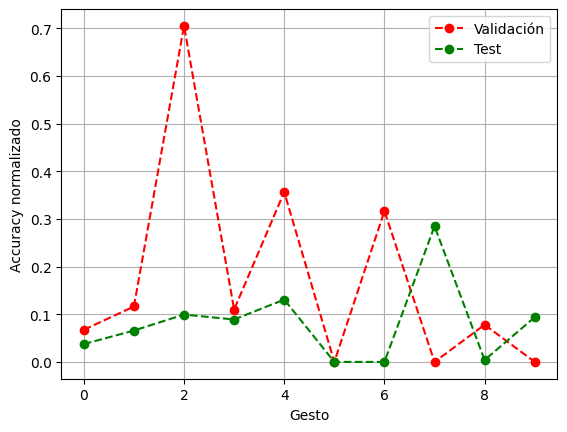

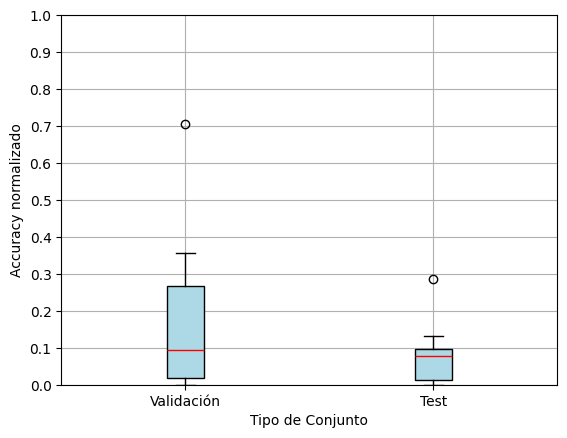

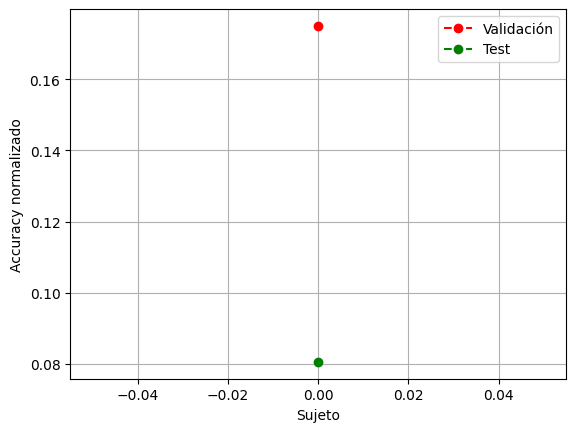

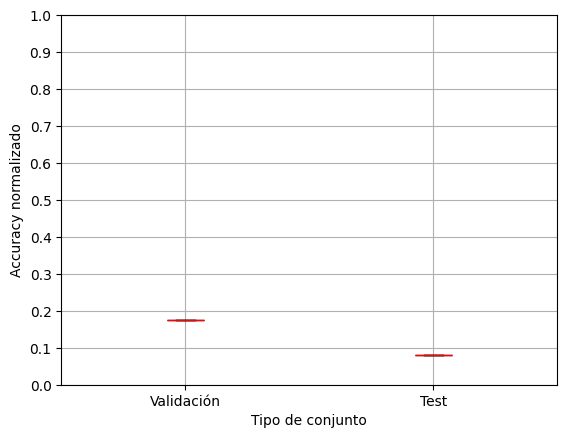

In [ ]:
val_vs_test(mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto, nombre_estrategia, False)

<ipython-input-19-d19f2339ed21>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto], labels=['Validación', 'Test'])


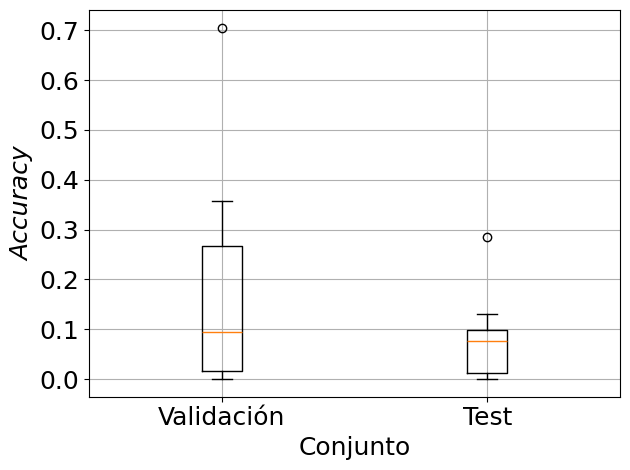

In [ ]:
plt.figure()
# Crear el boxplot tiempo inferencia por sujeto
plt.boxplot([mean_diagonales_val_x_gesto, mean_diagonales_test_x_gesto], labels=['Validación', 'Test'])

# Ajustar el tamaño del texto
plt.xlabel('Conjunto', fontsize=18)
plt.ylabel('Accuracy', fontsize=18, style='italic')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Añadir una cuadrícula y escala logarítmica
plt.grid()
plt.tight_layout()

# Guardar la figura
plt.savefig('Estrategia 2, boxplots.pdf', bbox_inches='tight')

## Estrategia 1

<ipython-input-24-96267f150a32>:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Test'], patch_artist=True,


TEST: Distribución por gesto. Media: 0.20901099, mediana: 0.24668425, std: 0.12186757
Std: 0.12186757


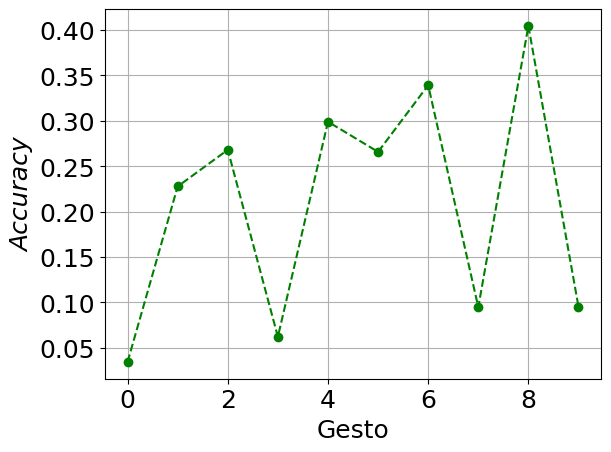

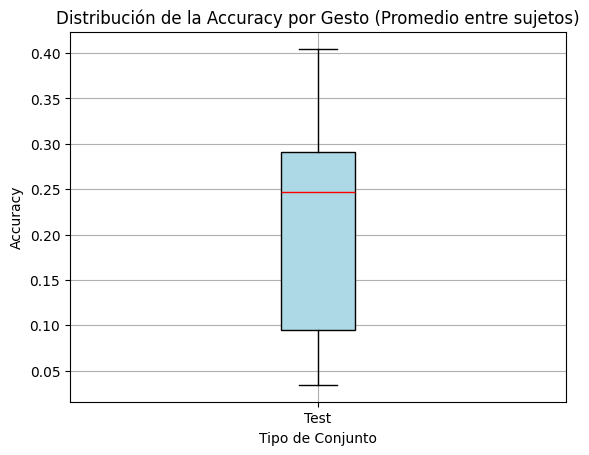

In [ ]:
nombre_exp = "GI_estrategia1_trainDB2_testDB3"

cant_exps = 1

acc_val_list = []
acc_test_list = []

for i in range(1, 2): # 11 es la cantidad de sujetos, por lo tanto, la cantidad de experimentos
  dir = nombre_exp # + str(i)
  os.chdir("/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3/" + dir) # me situo en el directorio
  # acc_val_list.append(joblib.load("cm_val_" + dir + ".pkl"))
  acc_test_list.append(joblib.load("cm_test_" + dir + ".pkl"))

def acc_x_clase(cm):
  # recibe como entrada la matriz de confusion
  diagonal_norm = np.zeros(cm.shape[0], dtype=np.float32)
  for i in range(cm.shape[0]):
    diagonal_norm[i] = cm[i, i]/np.sum(cm[i, :])

  return diagonal_norm

# diagonales_val = np.zeros((cant_exps, 10), dtype=np.float32)  # 11 cant de sujetos, 10 cant de gestos
diagonales_test = np.zeros((cant_exps, 10), dtype=np.float32)

for i in range(cant_exps):
  # diagonales_val[i, :] = acc_x_clase(acc_val_list[i])
  diagonales_test[i, :] = acc_x_clase(acc_test_list[i])

# mean_diagonales_val_e1 = np.nanmean(diagonales_val, axis = 0)
mean_diagonales_test_e1 = np.nanmean(diagonales_test, axis = 0)

plt.figure()
# plt.plot(mean_diagonales_val_e1, '--o', color='r')
plt.plot(mean_diagonales_test_e1, '--o', color='g')
plt.grid()
plt.xlabel('Gesto', fontsize=18)
plt.ylabel('Accuracy', fontsize=18, style='italic')
# plt.legend(['Validación', 'Test'])
# plt.title('Accuracy test promediada (entre experimentos) por gesto, Estrategia 1')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('Estrategia 1, accuracy test.pdf', bbox_inches='tight')

data = [mean_diagonales_test_e1]

plt.figure()  # figsize=(8,6)
plt.boxplot(data, labels=['Test'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.grid(True)
plt.xlabel('Tipo de Conjunto')
plt.ylabel('Accuracy')
plt.title('Distribución de la Accuracy por Gesto (Promedio entre sujetos)')

print('TEST: Distribución por gesto. Media: '+str(np.mean(mean_diagonales_test_e1))+ ', mediana: '+str(np.median(mean_diagonales_test_e1))+ ', std: '+str(np.std(mean_diagonales_test_e1)))
print("Std: "+str(np.std(mean_diagonales_test_e1)))


<ipython-input-14-483a4861afbf>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Gestos en conjunto de test'])


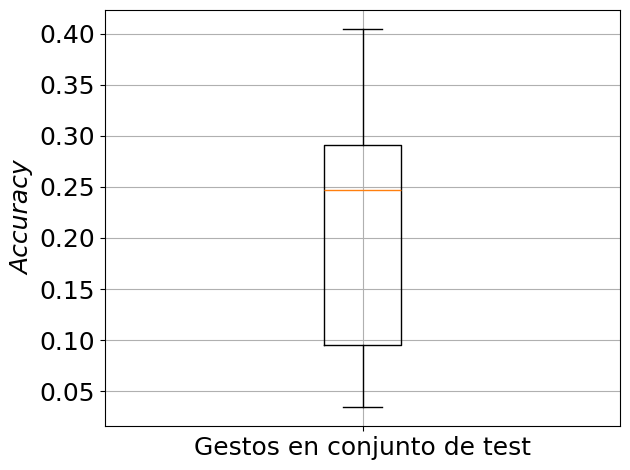

In [ ]:
plt.figure()
# Crear el boxplot tiempo inferencia por sujeto
plt.boxplot(data, labels=['Gestos en conjunto de test'])

# Ajustar el tamaño del texto
# plt.xlabel('Arquitecturas', fontsize=18)
plt.ylabel('Accuracy', fontsize=18, style='italic')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Añadir una cuadrícula y escala logarítmica
plt.grid()
plt.tight_layout()

# Guardar la figura
plt.savefig('Estrategia 1, boxplot test.pdf', bbox_inches='tight')

<ipython-input-7-51cd326d33d3>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mean_diagonales_test_e1_gesto, mean_diagonales_test_e1_sujeto], labels=['Gesto', 'Sujeto'])


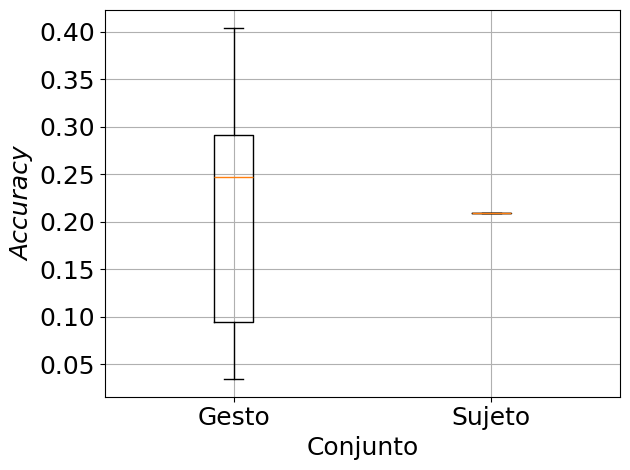

In [ ]:
mean_diagonales_test_e1_gesto = np.nanmean(diagonales_test, axis = 0)
mean_diagonales_test_e1_sujeto = np.nanmean(diagonales_test, axis = 1)


plt.figure()
# Crear el boxplot tiempo inferencia por sujeto
plt.boxplot([mean_diagonales_test_e1_gesto, mean_diagonales_test_e1_sujeto], labels=['Gesto', 'Sujeto'])

# Ajustar el tamaño del texto
plt.xlabel('Conjunto', fontsize=18)
plt.ylabel('Accuracy', fontsize=18, style='italic')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Añadir una cuadrícula y escala logarítmica
plt.grid()
plt.tight_layout()

# Guardar la figura
plt.savefig('Estrategia 2, boxplots.pdf', bbox_inches='tight')

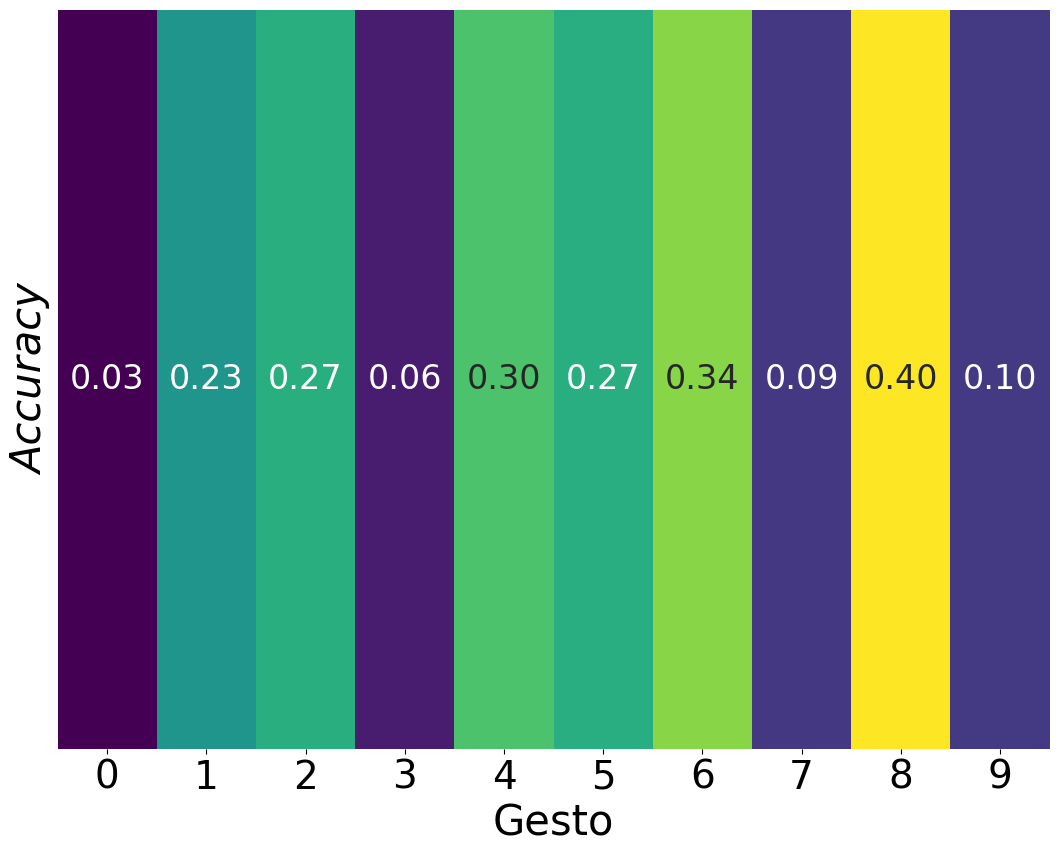

In [ ]:
# mapa_calor(diagonales_val, "Estrategia 1, visualización de accuracy en función de gesto y sujeto, validación", False)
mapa_calor_1fold(diagonales_test, "Estrategia 1, visualización de accuracy en función de gesto y sujeto, test", False)